# Project 1 - Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [31]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import linalg as la
from scipy.stats import chi2
from tabulate import tabulate


# Import this weeks LinearModels.py file
import LinearModels as lm

#Supress Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [32]:
dat = pd.read_csv('firms.csv')

In [33]:
dat.sample(5)

,firmid,year,lcap,lemp,ldsa
3086,258,1970,1.246196,0.387242,-0.101201
662,56,1970,1.382703,2.031049,2.173773
2179,182,1975,0.194555,0.794666,0.465070
2258,189,1970,-2.295680,-2.451450,-2.295350
3868,323,1972,-0.151328,0.003701,0.343343


#### We create the dataset 'data' with only the three first years in the time series

In [34]:
data = dat.loc[dat['year'] <= 1970]

In [35]:
data.year.unique()


array([1968, 1969, 1970])

# Descriptives

In [36]:
data.describe()

,firmid,year,lcap,lemp,ldsa
count,1323.000000,1323.000000,1.323000e+03,1.323000e+03,1.323000e+03
mean,221.000000,1969.000000,-3.432577e-08,5.291005e-09,3.253968e-08
std,127.353547,0.816805,1.367661e+00,1.212370e+00,1.238870e+00
min,1.000000,1968.000000,-3.864950e+00,-3.108660e+00,-3.433130e+00
25%,111.000000,1968.000000,-9.629080e-01,-8.435585e-01,-9.082370e-01
50%,221.000000,1969.000000,-1.016350e-01,-1.141760e-01,-1.142770e-01
75%,331.000000,1970.000000,9.708763e-01,8.067791e-01,8.648864e-01
max,441.000000,1970.000000,3.993508e+00,3.187258e+00,3.418170e+00


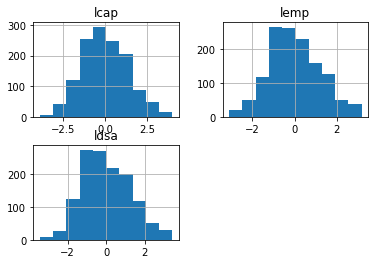

In [37]:
data[['lcap','lemp','ldsa']].hist();

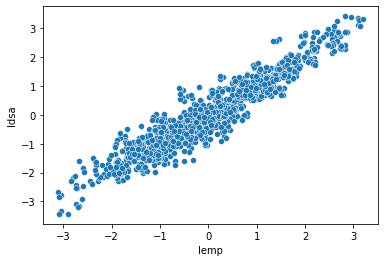

In [38]:
sns.scatterplot(x='lemp', y='ldsa', data=data); 

# Converting data to numpy format 

In [39]:
data.ldsa.values.shape

(1323,)

In [40]:
N = data.firmid.unique().size
T = data.year.unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=3


Extract data from `pandas` to `numpy` arrays. 

In [41]:
y = data.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = data.lemp.values.reshape((N*T,1))
k = data.lcap.values.reshape((N*T,1))
x = np.hstack([l, k])
#Before the hstack had ones before the l to create a constant
#We do not need this constant as the model is with no constant

# Lets also make some variable names
label_y = 'Log deflated sales'
label_x = [ 
    'ln of employment', 
    'ln adj. cap. stock',  
]

In [42]:
print(label_x)

print(x)

['ln of employment', 'ln adj. cap. stock']
[[-0.242185   0.9986017]
 [-0.241278   0.9252139]
 [-0.265134   0.8796163]
 ...
 [-1.94421   -1.61839  ]
 [-1.85658   -1.63503  ]
 [-1.53894   -1.45489  ]]



## We start by estimating using pooled OLS

In [43]:
#Estimate (1) by pooled OLS

# Estimate coefficients
b_hat = lm.est_ols(y,x)

# Print the results
for label, b_k in zip(label_x, b_hat):
    print(f'{label:16}: {b_k[0]:7.4f}')


ln of employment:  0.6860
ln adj. cap. stock:  0.2768


#### Calculate the standard errors of the coefficients.

In [44]:
# Calculate the residuals
resid = y - x @ b_hat

# Calculate estimate of variance of residuals
SSR = resid.T @ resid
K = x.shape[1]
sigma = SSR / (N*T - K)

# Calculate the variance-covariance matrix
cov = sigma * la.inv(x.T @ x)

# Calculate the standard errors 
# Make sure to output the result in a vector
se = np.sqrt(np.diag(cov)).reshape(-1,1)

#Print results
for label, b_k, se_k in zip(label_x, b_hat, se):
    print(f'{label:16}: {b_k[0]:7.4f}    ({se_k[0]:6.4f})')
    

ln of employment:  0.6860    (0.0194)
ln adj. cap. stock:  0.2768    (0.0172)


In [45]:
cov_xc = x.T @ resid
print(x.T)

[[-0.242185  -0.241278  -0.265134  ... -1.94421   -1.85658   -1.53894  ]
 [ 0.9986017  0.9252139  0.8796163 ... -1.61839   -1.63503   -1.45489  ]]


#### Estimating the model using OLS

In [46]:
# Estimate model using OLS
ols_result = lm.estimate(y,x, T=T)

# Print table
lm.print_table((label_y, label_x), ols_result, title="Pooled OLS", floatfmt='.4f')

Pooled OLS
Dependent variable: Log deflated sales

                      Beta      Se    t-values
------------------  ------  ------  ----------
ln of employment    0.6860  0.0112     61.1659
ln adj. cap. stock  0.2768  0.0099     27.8412
R² = 0.917
σ² = 0.042


### Estimating our model using Fixed effects

Doing the below steps
* Create the demeaning matrix Q.
* Demean x and y using the `perm` function and Q.
* Remove the columns in the demeaned x that are only zeroes and shorten the `label_x`. A function that does this is provided.
* Estimate y on x using the demeaned arrays.
* Print it out in a nice table.

In [47]:
def remove_zero_columns(x, label_x):
    """
    The function removes columns from a matrix that are all zeros and returns the updated matrix and
    corresponding labels.
    
    Args:
      x: The parameter `x` is a numpy array representing a matrix with columns that may contain zeros.
      label_x: The parameter `label_x` is a list that contains the labels for each column in the input
    array `x`.
    
    Returns:
      x_nonzero: numpy array of x with columns that are all zeros removed.
      label_nonzero: list of labels for each column in x_nonzero.
    """
    
    # Find the columns that are not all zeros
    nonzero_cols = ~np.all(x == 0, axis=0)
    
    # Remove the columns that are all zeros
    x_nonzero = x[:, nonzero_cols]
    
    # Get the labels for the columns that are not all zeros
    label_nonzero = [label_x[i] for i in range(len(label_x)) if nonzero_cols[i]]
    return x_nonzero, label_nonzero

In [48]:
# Transform the data
Q_T = np.eye(T) - np.tile(1/T, (T, T))
y_dot = lm.perm(Q_T, y)
x_dot = lm.perm(Q_T, x)

# Remove the columns that are only zeroes
x_dot, label_x_dot = remove_zero_columns(x_dot,label_x)

# Estimate 
fe_result = lm.estimate(y_dot, x_dot, transform='fe', T=T)
lm.print_table((label_y, label_x_dot), fe_result, title="Fixed Effects", floatfmt='.4f')

Fixed Effects
Dependent variable: Log deflated sales

                      Beta      Se    t-values
------------------  ------  ------  ----------
ln of employment    0.6004  0.0346     17.3515
ln adj. cap. stock  0.0502  0.0382      1.3143
R² = 0.284
σ² = 0.008


### Estimating our model using First differences 


Following the below steps
* Create the first difference matrix D.
* First difference x and y using the `perm` function and Q.
* Remove the columns in the first differenced x that are only zeroes and shorten the `label_x`.
* Estimate y on x using the first differenced arrays.
* Print it out in a nice table.

In [49]:
# Create transformation matrix
def fd_matrix(T):
    D_T = np.eye(T) - np.eye(T, k=-1) #k=-1 betyder vi forskyder til venstre.
    D_T = D_T[1:]
    return D_T

#D_T bliver T-1xT lang da vi fjerner første række (print for at se)
#matrice x er TxK
#x_diff er T-1xK

# Transform the data
D_T = fd_matrix(T)
y_diff = lm.perm(D_T, y)
x_diff = lm.perm(D_T, x)

# Remove the columns that are only zeroes
x_diff, label_x_diff = remove_zero_columns(x_diff,label_x)

# Estimate 
fd_result = lm.estimate(y_diff, x_diff, transform='fd', T=T-1)
lm.print_table((label_y, label_x_diff), fd_result, title="First Difference", floatfmt='.4f')

First Difference
Dependent variable: Log deflated sales

                      Beta      Se    t-values
------------------  ------  ------  ----------
ln of employment    0.5509  0.0258     21.3367
ln adj. cap. stock  0.0381  0.0306      1.2475
R² = 0.217
σ² = 0.007


### Estimating our model using Random effects



##### We will start by estimating the between estimator which will be used later on for the RE estimator (random effects), as the BE estimator is needed to calculate 


$$\hat{\lambda} = 1 - \sqrt{\frac{\widehat{\sigma}_{u}^{2}}{(\widehat{\sigma}_{u}^{2} + T\widehat{\sigma}_{c}^{2})}}. $$

In [50]:
# Transform the data

P_T = (1/T)*np.ones([1,T]) 
#ganger 1/T udenpå for at få gennemsnitsvektor, og laver matrice med 1'ere 
# hvor der bedes om én række og T kolonner, så vektoren får størrelsen 1xK


y_mean = lm.perm(P_T, y)
x_mean = lm.perm(P_T, x)

# Estimate 
be_result = lm.estimate(y_mean, x_mean, transform='be', T=T)
lm.print_table((label_y, label_x), be_result, title="Between Estimator", floatfmt='.4f')

Between Estimator
Dependent variable: Log deflated sales

                      Beta      Se    t-values
------------------  ------  ------  ----------
ln of employment    0.6856  0.0333     20.5565
ln adj. cap. stock  0.2778  0.0295      9.4042
R² = 0.921
σ² = 0.122


#### By now we have the two error variances we need to calculate 
$\hat{\sigma}_{c}^{2} = \hat{\sigma}_{w}^{2} - \frac{1}{T}\hat{\sigma}_{u}^{2}$

In [51]:
# Calculate lambda (note lambda is a reserved keyword in Python, so we use _lambda instead)
sigma2_u = fe_result['sigma2']
sigma2_w = be_result['sigma2'] #use sigma from BE estimation above
sigma2_c = sigma2_w - (1/T)*sigma2_u
_lambda = 1 - (sigma2_u/(sigma2_u+T*sigma2_c))**(1/2)

# Print lambda 
print(f'Lambda is approximately equal to {_lambda.item():.4f}.')

Lambda is approximately equal to 0.8509.


#### Now we can estimate the model using the methods of random effects

$$
\begin{align}
y_{it} & =\beta_{K}\textit{k}_{it}+\beta_{L}\textit{l}_{it}+\nu_{it} \tag{3}
\end{align}
$$


Considering that we will be quasi-demeaning each firm with $\hat{\lambda}$, we will again use the `perm` function. This time, we pass it through the following transformation matrix,

$$
\mathbf{C}_{T}:=\mathbf{I}_{T} - \hat{\lambda}\mathbf{P}_{T},
$$

where $\mathbf{P}_{T}$ is the $1 \times T$ transformation vector we used earlier to calculate the mean of each firm.


In [52]:
# Transform the data
C_T = np.eye(T) - _lambda*P_T
y_re = lm.perm(C_T,y)
x_re = lm.perm(C_T,x)

# Estimate 
re_result = lm.estimate(y_re, x_re, transform='re', T=T)
lm.print_table((label_y, label_x), re_result, title="Random Effects", floatfmt='.4f')

Random Effects
Dependent variable: Log deflated sales

                      Beta      Se    t-values
------------------  ------  ------  ----------
ln of employment    0.6912  0.0235     29.4669
ln adj. cap. stock  0.2477  0.0214     11.6004
R² = 0.797
σ² = 0.008


#### We will now conduct the Hausman test

This is to test whether RE should be chosen or FE. 
If the test is rejected RE should not be chosen.
If RE.1 (b) does not hold and random effects estimation is inconsistent whereas fixed effects estimator is consistent. 


In [53]:
# Unpack
b_fe = fe_result['b_hat']
b_re = re_result['b_hat'] 
cov_fe = fe_result['cov']
cov_re = re_result['cov'] 

# Calculate the test statistic
b_diff = b_fe - b_re
cov_diff = cov_fe - cov_re
H = b_diff.T @ la.inv(cov_diff) @ b_diff

# Find critical value and p-value at 5% significance level of chi^2 with M degrees of freedom
M = len(b_fe)
crit_val = chi2.ppf(0.95, M)
p_val = 1-chi2.cdf(H[0], M)

# Print the results
print(f'The test statistic is {H.item():.2f}.')
print(f'The critical value at a 5% significance level is {crit_val:.2f}.')
print(f'The p-value is {p_val.item():.8f}.')

The test statistic is 50.88.
The critical value at a 5% significance level is 5.99.
The p-value is 0.00000000.


#### Testing if FE.3 holds through FD-residuals

In [54]:
# Calculating FD-residuals

residual_diff = y_diff - x_diff@fd_result['b_hat']
residualit_diff = residual_diff.reshape(-1,2)
print(residualit_diff.shape)

(441, 2)


In [55]:
# Computing correlation matrix

corrmat = np.corrcoef(residualit_diff, rowvar=False)


## Test om beta'er fra valgte FD estimator er god ved en wald-test

#### : 

$$
\begin{align}
H_0 & : R\beta=r \tag{}
\end{align}
$$

We are interested in $H_0: R\beta=r$.
R: QxK with rank $R= Q =< K$
r: Qx1

Wald statistic:


$$
\begin{align}
W & := (R\beta-r)'[R\hat{Avar(\beta)}R'](R\hat{\beta}-r) \tag{}
\end{align}
$$

Under $H_0$, $W \rightarrow_d \chi^2_Q$
Q: degrees of freedom, is the no. of restrictions we are trying to test

Wald test: reject $H_0$ at level $\alpha \Leftrightarrow$ $W>(1-\alpha)$-quantile of $\chi^2_Q$

We choose $R=[1 1]$ and r=1 as we wanna test the null-hypothesis of $\beta_K+\beta_L=1$

In [56]:
R = np.ndarray([1 ,1])
r = 1
print(R)
b_hat_fe = fe_result['b_hat']
cov_fe = fe_result['cov']

Wald = (R * b_hat_fe-r).T @ la.inv(R * cov_fe * R.T) @ (R * b_hat_fe-r)

[[1.]]


In [57]:
R = np.ones(2)
R = R.reshape(1,-1)
r = 1
print(R.shape)

(1, 2)


In [58]:
b_hat_fe = fe_result['b_hat']
cov_fe = fe_result['cov']

Wald = (R @ b_hat_fe-r).T @ la.inv(R @ cov_fe @ R.T) @ (R @ b_hat_fe-r)

print(Wald)

[[66.06939843]]


In [59]:
# Find critical value and p-value at 5% significance level of t with M degrees of freedom
Q = r
crit_val = chi2.ppf(0.95, Q)
p_val = 1-chi2.cdf(Wald[0], Q)

# Print the results
print(f'The test statistic is {Wald.item():.2f}.')
print(f'The critical value at a 5% significance level is {crit_val:.2f}.')
print(f'The p-value is {p_val.item():.8f}.')

The test statistic is 66.07.
The critical value at a 5% significance level is 3.84.
The p-value is 0.00000000.


### Wald-test for first differences


In [60]:
R = np.ndarray([1 ,1])
r = 1
print(R)
b_hat_fd = fd_result['b_hat']
cov_fd = fd_result['cov']

Wald = (R * b_hat_fd-r).T @ la.inv(R * cov_fd * R.T) @ (R * b_hat_fd-r)

[[1.]]


In [61]:
R = np.ones(2)
R = R.reshape(1,-1)
r = 1
print(R.shape)

(1, 2)


In [62]:
b_hat_fd = fd_result['b_hat']
cov_fd = fd_result['cov']

Wald = (R @ b_hat_fd-r).T @ la.inv(R @ cov_fd @ R.T) @ (R @ b_hat_fd-r)

print(Wald)

[[132.2756122]]


In [63]:
# Find critical value and p-value at 5% significance level of t with M degrees of freedom
Q = r
crit_val = chi2.ppf(0.95, Q)
p_val = 1-chi2.cdf(Wald[0], Q)

# Print the results
print(f'The test statistic is {Wald.item():.2f}.')
print(f'The critical value at a 5% significance level is {crit_val:.2f}.')
print(f'The p-value is {p_val.item():.8f}.')

The test statistic is 132.28.
The critical value at a 5% significance level is 3.84.
The p-value is 0.00000000.
